# Testing Redshift Tomographic Bins

In [ ]:
import pyccl as ccl

print(f"I am using pyccl version {ccl.__version__}")
import numpy as np
import scripts.plotting as p
import matplotlib.pyplot as plt
from scripts.nz_metrics import NZMetrics
from scripts.presets import Presets
from scripts.tomographic_binning import TomographicBinning
from scripts.srd_redshift_distributions import SRDRedshiftDistributions

I am using pyccl version 3.0.2


In [57]:
# This analysis will be done for a cosmology with the following parameters
# if you want to change the cosmology, you can do it here or just run without it.
# For now, we will keep it as is.
# cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)

# The class has default values for the maximal redshift and the resolution of redshifts.
# You can change them if you want to or run the default values.
# Since we are investigating the impact of the resolution of redshifts,
# we will keep the maximal redshift as is (for now) and only change the redshift resolution.
redshift_max = 3.5
redshift_resolution_1 = 300  # this is the first resolution of redshifts
redshift_resolution_2 = 10000  # this is the second resolution of redshifts
forecast_year = "1"
# Please note that the redshift resolution is the number of redshifts between 0 and redshift_max.
# Additionally, a lot of parametric sweeping is already coded into helper functions
# so we will not need to worry about that for now.

# We will also investigate ell binning but for this particular exercise,
# we will keep the ell binning at default values.
# ell_min = 20
# ell_max = 2000
# n_ell = 50

# We now initialize the class by only passing the redshift information.
presets = Presets(
    redshift_max=redshift_max,
    redshift_resolution=redshift_resolution_2,
    forecast_year=forecast_year,
)
redshift_range = presets.redshift_range
bin = TomographicBinning(presets)
source_bins = bin.source_bins()
lens_bins = bin.lens_bins()
source_bin_centers = bin.source_bin_centers()
lens_bin_centers = bin.lens_bin_centers()
sources = SRDRedshiftDistributions(presets).source_sample()
lenses = SRDRedshiftDistributions(presets).lens_sample()

nzm = NZMetrics(presets)

Data saved to data_output/redshift_distributions/source_bins_y1.npy
Data saved to data_output/redshift_distributions/lens_bins_y1.npy
Data saved to data_output/redshift_distributions/source_sample_y1.npy
Data saved to data_output/redshift_distributions/lens_sample_y1.npy


### Generate arrays of redshift values that follow the distributions

In [58]:
N = 10**9  # Number of Monte Carlo draws

bin_number = 5

z_values = np.random.choice(
    redshift_range,
    size=N,
    p=source_bins[bin_number - 1] / source_bins[bin_number - 1].sum(),
)

### Check if most generated elements are unique

In [59]:
z_values
unique, counts = np.unique(z_values, return_counts=True)
repeated_elements = unique[counts > 1]
print(f"Number of repeated elements: {len(repeated_elements)}")

Number of repeated elements: 7983


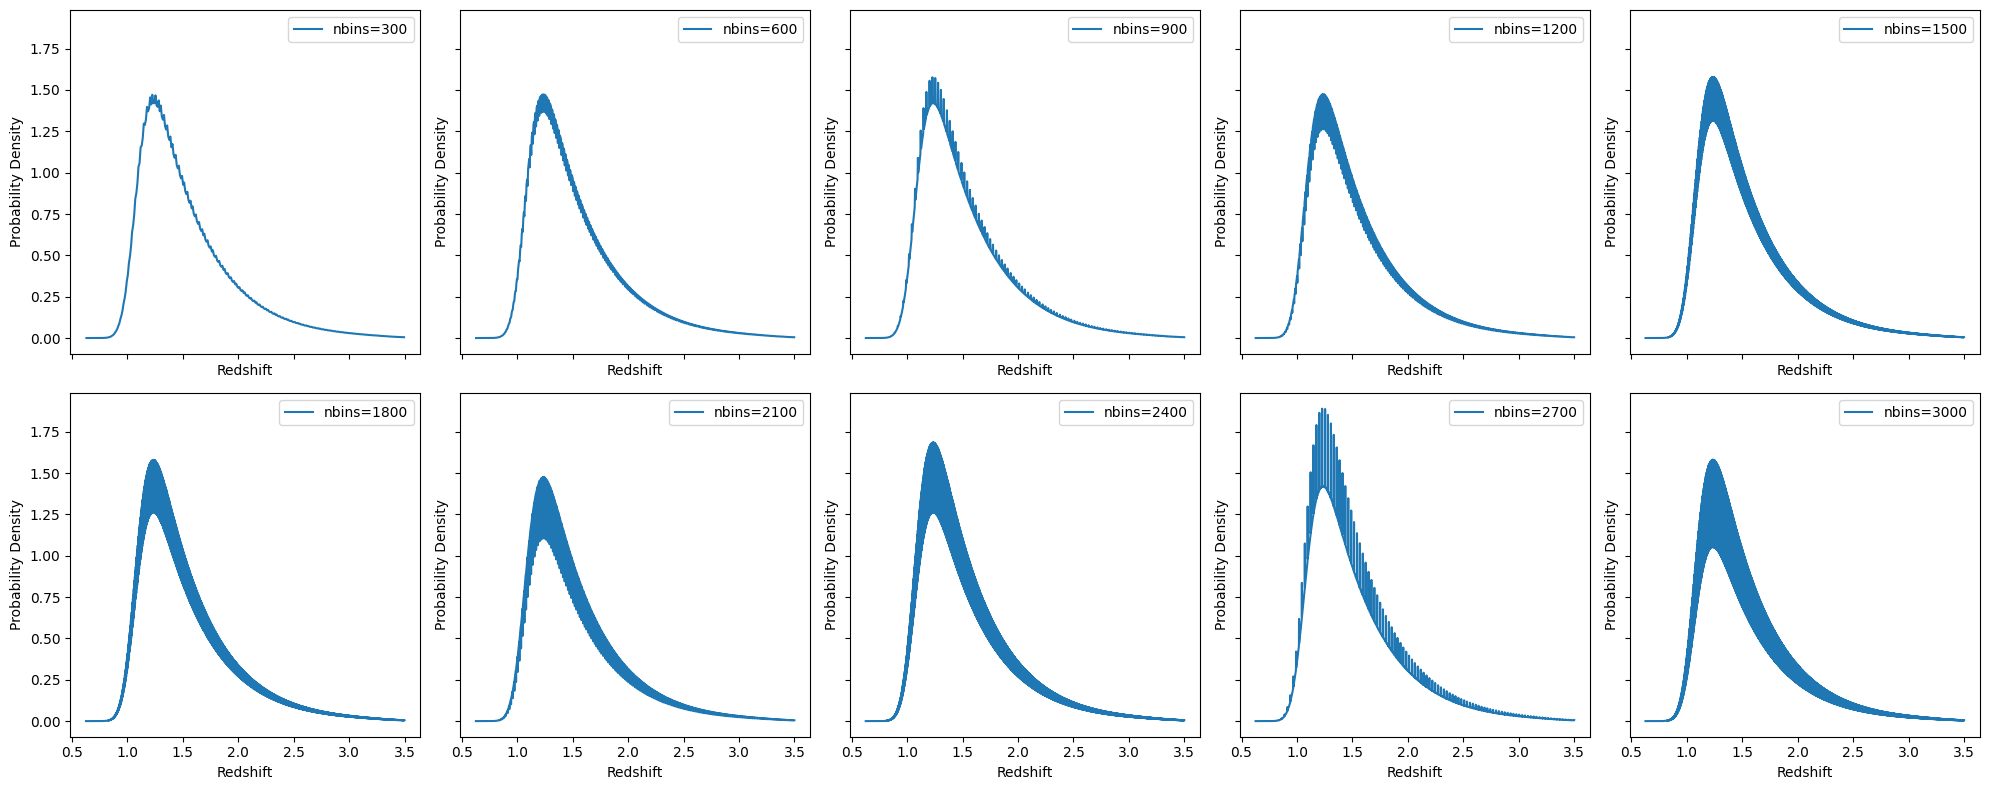

In [60]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8), sharex=True, sharey=True)
axs = axs.flatten()

for idx, bins in enumerate(300 * (np.arange(10) + 1)):
    hist, bin_edges = np.histogram(z_values, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    axs[idx].plot(bin_centers, hist, label=f"nbins={bins}")
    axs[idx].set_xlabel("Redshift")
    axs[idx].set_ylabel("Probability Density")
    axs[idx].legend()

plt.tight_layout()
plt.show()